## Fake Bill Classification with Kaggle's Dataset

 The dataset includes 1500 rows and 7 columns:

 - is_genuine: boolean

 - diagonal: float

 - height_left: float

 - height_right: float

 - margin_low: float

 - margin_upper: float

 - length: float

 - Idea of projects with this dataset:
    Predicting the missing values with a linear regression or a KNN imputer
    Comparing classification such as logistic regression or KNN with an unsupervised model such as K-Means to predict the authenticity of the bills
    Trying to do a PCA or a Kernel Transform to create a clearer separation between the Genuine and Fake Bills.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from svm_margin_plot import plot_svm_boundary

data = pd.read_csv('./Datasets/fake_bills.csv' , sep=';')
print(data.sample(10))

      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
989         True    171.68       103.90        103.68        3.78       2.74   
620         True    171.87       103.40        103.82        4.06       2.94   
283         True    172.47       103.57        103.89        4.60       3.20   
990         True    171.74       103.90        103.60        3.87       2.89   
676         True    171.69       103.90        104.13        4.07       2.92   
1007       False    171.83       104.13        104.52        4.94       3.27   
1003       False    172.02       104.33        104.33        5.19       3.21   
980         True    172.12       104.08        104.49        4.09       3.56   
778         True    171.92       103.60        103.92        4.33       3.02   
131         True    171.27       104.14        103.78        3.91       2.69   

      length  
989   113.60  
620   113.02  
283   112.93  
990   113.36  
676   113.52  
1007  111.72  
1003  111.99  

In [2]:
# Mapping the 'is_genuine' column
data['is_genuine'] = data['is_genuine'].map({True : 0 , False: 1})

- Correlation of Features with Label

length         -0.849285
diagonal       -0.132756
height_left     0.379833
height_right    0.485092
margin_up       0.606262
margin_low      0.783032
is_genuine      1.000000
Name: is_genuine, dtype: float64


<Axes: >

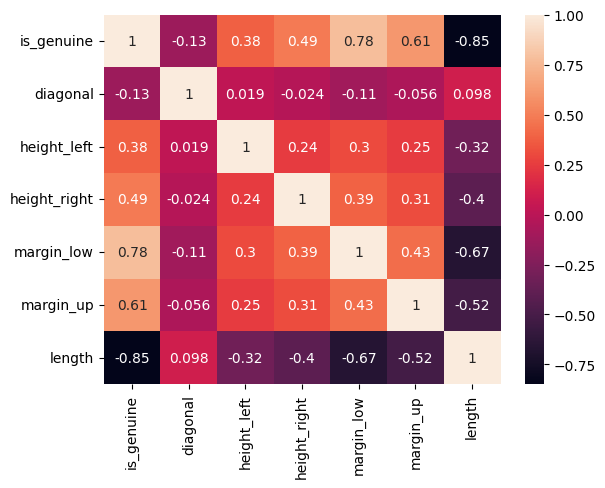

In [3]:
print(data.corr()['is_genuine'].sort_values())
sns.heatmap(data=data.corr() , annot=True)

- Dropping Columns which less correlate with 'is_genuine' Label

In [4]:
data = data.drop(['length' , 'diagonal'] , axis=1)

- checking for Null values

In [5]:
print(data.isnull().sum()) # 37 null values found in 'margin_low' feature

is_genuine       0
height_left      0
height_right     0
margin_low      37
margin_up        0
dtype: int64


- Performing Mean Imputation for Null values in 'margin_low' feature

In [6]:
data['margin_low'] = data['margin_low'].fillna(data['margin_low'].mean())

- Seprating Label with features

In [7]:
X = data.drop('is_genuine' , axis=1)
y = data['is_genuine']

- Checking for possible imbalance

is_genuine
0    1000
1     500
Name: count, dtype: int64


<Axes: ylabel='count'>

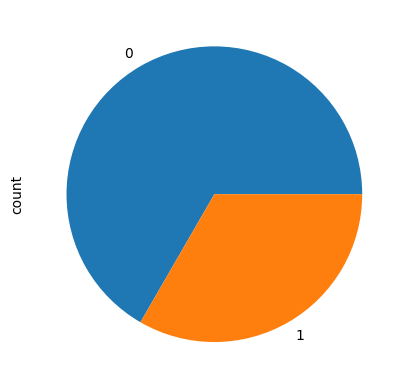

In [8]:
print(y.value_counts())
y.value_counts().plot.pie() # pandas in-built function to visualize a pie-chart

- Out of 1500 bills in dataset only 500 are fake. If the need arises , we can perform resampling...

- Data Prepration

In [9]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X , y , random_state=42 , test_size=0.4)


- Making a KNN Model with Pipeline and GridSearchCV

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([ ('scaler' , StandardScaler()) , ('model' , KNeighborsClassifier())])

params_grid = {
    'model__n_neighbors':[x for x in range(2 , 31)],
}

GridSearch_KNN = GridSearchCV(estimator=pipe , param_grid=params_grid , cv=10)
GridSearch_KNN.fit(X_train , y_train)

print(GridSearch_KNN.best_params_)


{'model__n_neighbors': 7}


- Testing for KNN

In [11]:
from sklearn.metrics import confusion_matrix , classification_report

y_pred = GridSearch_KNN.predict(X_test)


print("Confusion Matrix : \n" , confusion_matrix(y_test , y_pred))
print("Classification Report : \n" , classification_report(y_test , y_pred))

Confusion Matrix : 
 [[383   9]
 [ 18 190]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       392
           1       0.95      0.91      0.93       208

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



- KNN itself performed very well but let's try with Support Vector Classifier

In [13]:
from sklearn.svm import SVC

params_grid = {
    'model__C':[0.1 , 0.2 , 0.3 , 0.4 , 0.5],
    'model__kernel':['linear' , 'rbf'],
    'model__gamma':[0.1 , 0.2 , 0.3 , 0.4 , 0.5]
}

pipe = Pipeline([ ('scaler' , StandardScaler()) , ('model' , SVC())])

GridSearch_SVC = GridSearchCV(estimator=pipe , param_grid=params_grid , cv=10)
GridSearch_SVC.fit(X_train , y_train)

print(GridSearch_SVC.best_params_)

{'model__C': 0.3, 'model__gamma': 0.2, 'model__kernel': 'rbf'}


- Testing for Support Vector Classifier

In [14]:
y_pred = GridSearch_SVC.predict(X_test)

print("Confusion Matrix : \n" , confusion_matrix(y_test , y_pred))
print("Classification Report : \n" , classification_report(y_test , y_pred))

Confusion Matrix : 
 [[385   7]
 [ 17 191]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       392
           1       0.96      0.92      0.94       208

    accuracy                           0.96       600
   macro avg       0.96      0.95      0.96       600
weighted avg       0.96      0.96      0.96       600



Support Vector Classifier does improves precision by a bit thus both Models can be used as a Solution to the Bill Classification problem